# Intro to Deep Learning Final
## My Take on Machine Image Processing of Street Signs

### Imports

In [3]:
# Basic Imports
import os
import numpy as np
import pandas as pd
import re
import math
import random
import shutil

# Plotting Imports
from pywaffle import Waffle
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap


# Image Processing Imports
from PIL import Image
from IPython.display import display
from IPython.display import Video
from skimage.transform import resize
import cv2

# sklearn Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


# Tensor Flow and Keras Imports
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF
from torchsummary import summary

### Processing the First Dataset:

The following is part of the LISA Dataset, which I found on Kaggle. It comes with a bunch of different images organized by file name and directory, and a csv with the following information:
- 'Filename'
- 'Annotation tag'
- 'Upper left corner X'
- 'Upper left corner Y'
- 'Lower right corner X'
- 'Lower right corner Y'
- 'Occluded,On another road'
- 'Origin file'
- 'Origin frame number'
- 'Origin track'
- 'Origin track frame number'


In [2]:
current_directory = os.getcwd()

file_path = os.path.join(current_directory, 'allAnnotations.csv')
annotations_df = pd.read_csv(file_path, delimiter=';')
annotations_df.head()
annotations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7855 entries, 0 to 7854
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Filename                   7855 non-null   object
 1   Annotation tag             7855 non-null   object
 2   Upper left corner X        7855 non-null   int64 
 3   Upper left corner Y        7855 non-null   int64 
 4   Lower right corner X       7855 non-null   int64 
 5   Lower right corner Y       7855 non-null   int64 
 6   Occluded,On another road   7855 non-null   object
 7   Origin file                7855 non-null   object
 8   Origin frame number        7855 non-null   int64 
 9   Origin track               7855 non-null   object
 10  Origin track frame number  7855 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 675.2+ KB


In [3]:
speed_limits = [
    'speedLimit15', 'speedLimit25', 'speedLimit30', 'speedLimit35', 
    'speedLimit40', 'speedLimit45', 'speedLimit50', 'speedLimit55', 'speedLimit65', 'speedLimitUrdbl'
]
def clean_annotation(tag):
    if tag in speed_limits:
        if 'Urdbl' in tag:
            return 'unknown'
        else:
            return ''.join(filter(str.isdigit, tag))
    else:
        return 'na_sign'
annotations_df['Cleaned Annotation'] = annotations_df['Annotation tag'].apply(clean_annotation)
annotations_df = annotations_df.set_index('Cleaned Annotation').sort_index()
print(annotations_df.columns.values)
annotations_df = annotations_df.rename(columns={
    'Filename': 'Filename',
    'Annotation tag': 'OG Tag',
    'Upper left corner X': 'ULX',
    'Upper left corner Y': 'ULY',
    'Lower right corner X': 'LRX',
    'Lower right corner Y': 'LRY',
    'Occluded,On another road': 'Occluded',
    'Origin file': 'OG Filename',
    'Origin frame number': 'Frame Num',
    'Origin track': 'OG Track',
    'Origin track frame number': 'OG Track Frame Num'
})
annotations_df['OG Tag'].head()

['Filename' 'Annotation tag' 'Upper left corner X' 'Upper left corner Y'
 'Lower right corner X' 'Lower right corner Y' 'Occluded,On another road'
 'Origin file' 'Origin frame number' 'Origin track'
 'Origin track frame number']


Cleaned Annotation
15    speedLimit15
15    speedLimit15
15    speedLimit15
15    speedLimit15
15    speedLimit15
Name: OG Tag, dtype: object

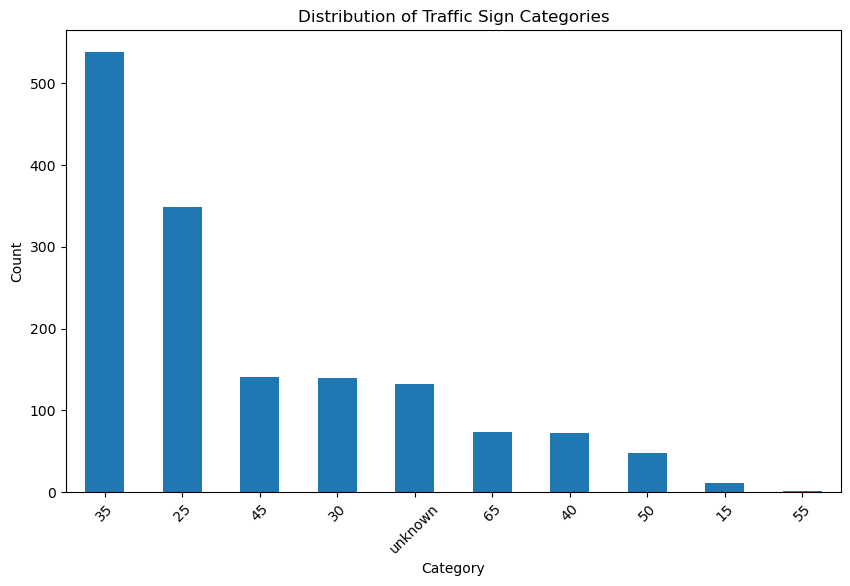

In [4]:
category_counts = annotations_df[annotations_df.index != 'na_sign'].index.value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Distribution of Traffic Sign Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

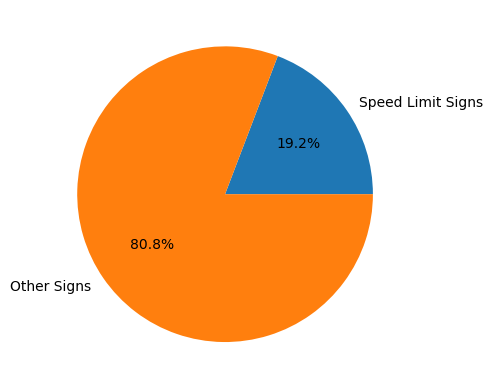

In [5]:
speed_sign_count = annotations_df[annotations_df.index != 'na_sign'].count(axis=0)
na_sign_count = annotations_df[annotations_df.index == 'na_sign'].count(axis=0)
plt.pie([speed_sign_count[0],na_sign_count[0]], labels=['Speed Limit Signs', 'Other Signs'],autopct='%1.1f%%')
plt.show()

Traffic Sign:  speedLimit35


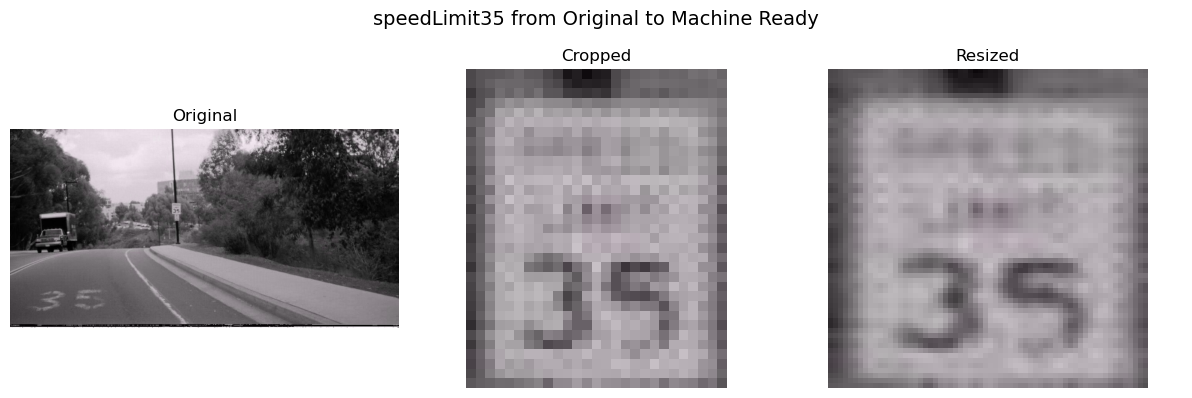

In [6]:
iloc_val = 1000
look_at_img = annotations_df.reset_index()
file = look_at_img['Filename'].iloc[iloc_val]
img = cv2.imread(f'{current_directory}/{file}')
#plt.imshow(img)
ULX = look_at_img['ULX'].iloc[iloc_val]
ULY =look_at_img['ULY'].iloc[iloc_val]
LRX = look_at_img['LRX'].iloc[iloc_val]
LRY =look_at_img['LRY'].iloc[iloc_val]
#print(ULX, ULY, LRX, LRY)
crop_img = img[ULY:LRY, ULX:LRX]
tag = look_at_img['OG Tag'].iloc[iloc_val]
print("Traffic Sign: ", tag)
resize = cv2.resize(crop_img, (64, 64), 
               interpolation = cv2.INTER_CUBIC)
images = [img,crop_img,resize]
titles = ['Original','Cropped','Resized']

plt.figure(facecolor='none', figsize=(12, 4))
plt.suptitle(f'{tag} from Original to Machine Ready', fontsize=14)
plt.axis('off')
for i in range(len(images)):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout(pad=1)
plt.show()

In [8]:
def setup_directories(df):
    base_path = os.path.join(os.getcwd(), 'reshaped_image_data')
    os.makedirs(base_path, exist_ok=True)
    unique_tags = df['OG Tag'].unique()
    for tag in unique_tags:
        tag_path = os.path.join(base_path, tag)
        os.makedirs(tag_path, exist_ok=True)
    print("All necessary directories are set up.")


tag_types = annotations_df['OG Tag'].unique()

def reformat_images(df, img_name, iloc_val):
    current_directory = os.getcwd()
    image_data_path = os.path.join(current_directory, 'reshaped_image_data')
    
    # Get the tag information from the DataFrame
    look_at_img = df.reset_index()
    file = look_at_img['Filename'].iloc[iloc_val]
    img_info = df.loc[df['Filename'] == file].reset_index(drop=True)
    
    # Read the image from the specified directory
    img_path = os.path.join(current_directory, file)
    img = cv2.imread(img_path)

    # Extract the cropping coordinates from the DataFrame
    ULX, ULY = int(img_info['ULX'].iloc[0]), int(img_info['ULY'].iloc[0])
    LRX, LRY = int(img_info['LRX'].iloc[0]), int(img_info['LRY'].iloc[0])
    crop_img = img[ULY:LRY, ULX:LRX]
    
    # Resize the cropped image
    resize = cv2.resize(crop_img, (64, 64), interpolation=cv2.INTER_CUBIC)

    # Determine the directory to save based on the tag
    tag = img_info['OG Tag'].iloc[0]
    tag_directory = os.path.join(image_data_path, tag)
    # Get the next available filename using the next_image_filename function
    next_filename = next_image_filename(tag_directory)
    save_path = os.path.join(tag_directory, next_filename)
    # Save the resized image to the determined path
    cv2.imwrite(save_path, resize)
    
    #print("Traffic Sign:", tag)
    return save_path, tag_directory

def next_image_filename(directory):
    pattern = re.compile(r'^(\d+)\.png$')
    max_num = 0
    found = False
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            num = int(match.group(1))
            found = True
            if num > max_num:
                max_num = num
    if found:
        return f"{max_num + 1}.png"
    else:
        return "1.png"

setup_directories(annotations_df)
past_iloc = int(annotations_df.shape[0])
td_old = []
for i in range(0,past_iloc):
    iloc_val=i
    file = look_at_img['Filename'].iloc[iloc_val]
    _, td = reformat_images(annotations_df, file, iloc_val)
    if (td not in td_old):
        print(td)
        td_old.append(td)
    if i % 501 == 0 or i == past_iloc:
        print(f"Currently at {i / past_iloc * 100:.2f}%")

All necessary directories are set up.
/Users/eashan/Coursera/Deep Learning Final/reshaped_image_data/speedLimit15
Currently at 0.00%
/Users/eashan/Coursera/Deep Learning Final/reshaped_image_data/speedLimit25
/Users/eashan/Coursera/Deep Learning Final/reshaped_image_data/speedLimit30
/Users/eashan/Coursera/Deep Learning Final/reshaped_image_data/speedLimit35
Currently at 6.38%
Currently at 12.76%
/Users/eashan/Coursera/Deep Learning Final/reshaped_image_data/speedLimit40
/Users/eashan/Coursera/Deep Learning Final/reshaped_image_data/speedLimit45
/Users/eashan/Coursera/Deep Learning Final/reshaped_image_data/speedLimit50
/Users/eashan/Coursera/Deep Learning Final/reshaped_image_data/speedLimit55
/Users/eashan/Coursera/Deep Learning Final/reshaped_image_data/speedLimit65
/Users/eashan/Coursera/Deep Learning Final/reshaped_image_data/merge
/Users/eashan/Coursera/Deep Learning Final/reshaped_image_data/addedLane
/Users/eashan/Coursera/Deep Learning Final/reshaped_image_data/rampSpeedAdviso

### Dataset 2: 

I don't like the fact that there are certain folders that aren't that full and I don't think it would hurt adding in a dataset from another source also of signs. This is one that I adapted from roboflow and will add on, manually editing the folder names to match up with each other

In [13]:
rf_topdir = os.path.join(current_directory, 'roboflow_data')
image_dir = os.path.join(current_directory, 'reshaped_image_data')

rf_data_labels=os.listdir(rf_topdir)

for label in rf_data_labels:
    im_num=1000
    label_img_dir = os.path.join(rf_topdir, label)
    if not os.path.isdir(label_img_dir):
        continue
    label_images = os.listdir(label_img_dir)
    print('*'*10,label)
    for img_name in label_images:
        try:
            img=cv2.imread(os.path.join(label_img_dir, img_name))
            print(f'{label}/{img_name}: {img.shape}')
            resized_img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC)
            fname = f'{im_num}.png'
            dest_path = os.path.join(image_dir, label, fname)
            cv2.imwrite(dest_path, resized_img)
        except Exception as ex:
            print(f'Error reading image {label}/{img_name}: {ex}')

        im_num += 1

********** stopAhead
stopAhead/o13_jpg.rf.e5bad3750f9c3764ee95b14c02c6cda7.jpg: (604, 604, 3)
stopAhead/o13_jpg.rf.e1083c4514753af9beae902025078b54.jpg: (604, 604, 3)
stopAhead/o14_jpg.rf.751fd21aab7525c542340d68e6303d39.jpg: (604, 604, 3)
stopAhead/o14_jpg.rf.ce3106658c7cf9702007959a9859584b.jpg: (604, 604, 3)
stopAhead/o13_jpg.rf.da49d8c28881ce5fdc11a5be19d97ebe.jpg: (604, 604, 3)
stopAhead/o13_jpg.rf.f93c9865e647003807b0a79bca6e5c26.jpg: (604, 604, 3)
stopAhead/SAM_0823_JPG.rf.2e6ec6af383fa61d9677bdb419e8bc1a.jpg: (604, 604, 3)
stopAhead/SAM_0823_JPG.rf.658b3e53b03f2f11d4ef5c744b9b1dd6.jpg: (604, 604, 3)
stopAhead/SAM_0823_JPG.rf.9cc71a69e79331681b100c276d705f6e.jpg: (604, 604, 3)
stopAhead/o13_jpg.rf.733f61b2574623a3a13394206479dce9.jpg: (604, 604, 3)
stopAhead/o13_jpg.rf.f8c151f3a83204b3ad11fadeaeea4ada.jpg: (604, 604, 3)
stopAhead/o13_jpg.rf.c4f5d3e659c14c785fb046c8efcf070f.jpg: (604, 604, 3)
stopAhead/o14_jpg.rf.0702d60041274f478e8a92b6a0974690.jpg: (604, 604, 3)
stopAhead/o13_j

In [18]:
def sizing_algorithm(size, detailed_list=False, summary=False, min_columns=1, max_columns=None, min_rows=1, max_rows=None, flip_rows_columns=False):
    size = int(size)
    a = max(min_columns, 1) if min_columns and min_columns > 0 else 1
    b = min(max_rows, size) if max_rows and max_rows > 0 and max_rows <= size else size
    
    if max_columns and (max_columns < 1 or max_columns > size):
        max_columns = None
    if min_rows and (min_rows < 1 or min_rows > size):
        min_rows = 1
    
    if max_rows and min_columns and max_rows < min_columns:
        max_rows, min_columns = min_columns, max_rows  # Flip values to ensure a <= b

    list_of_dicts = []

    # Ensure b_current starts correctly
    b_current = math.ceil(size / a)

    while a <= b_current:
        b_current = math.ceil(size / a)
        if (max_columns and a > max_columns) or (min_rows and b_current < min_rows):
            a += 1
            continue
        
        mod_val = a * b_current - size
        diff_val = abs(b_current - a)  # Ensure diff_val is non-negative by using abs
        score = diff_val * (mod_val+1)

        if mod_val >= 0 and a <= b_current:  # Ensure no negative mods and a <= b_current
            list_of_dicts.append({
                "a": a,
                "b": b_current,
                "mod": mod_val,
                "diff": diff_val,
                "scored": score
            })
        a += 1

    sorted_pairs = sorted(list_of_dicts, key=lambda x: (x["scored"], x["mod"], x["diff"]))

    if len(sorted_pairs) > 1 and sorted_pairs[0]['a'] == 1:
        sorted_pairs.pop(0)

    if summary and sorted_pairs:
        top = sorted_pairs[0]
        print(f"Optimal column/row (a and b) options are a={top['a']} and b={top['b']} with a mod of {top['mod']} empty slots and the lowest score of {top['scored']}.")

    if flip_rows_columns:
        for pair in sorted_pairs:
            pair['a'], pair['b'] = pair['b'], pair['a']

    if detailed_list:
        return {"a": top['a'], "b": top['b']}, sorted_pairs
    else:
        if sorted_pairs:
            top = sorted_pairs[0]
            return {"a": top['a'], "b": top['b']}
        return {}


#tag_types = annotations_df['OG Tag'].unique()
#sizing_algorithm(tag_types)

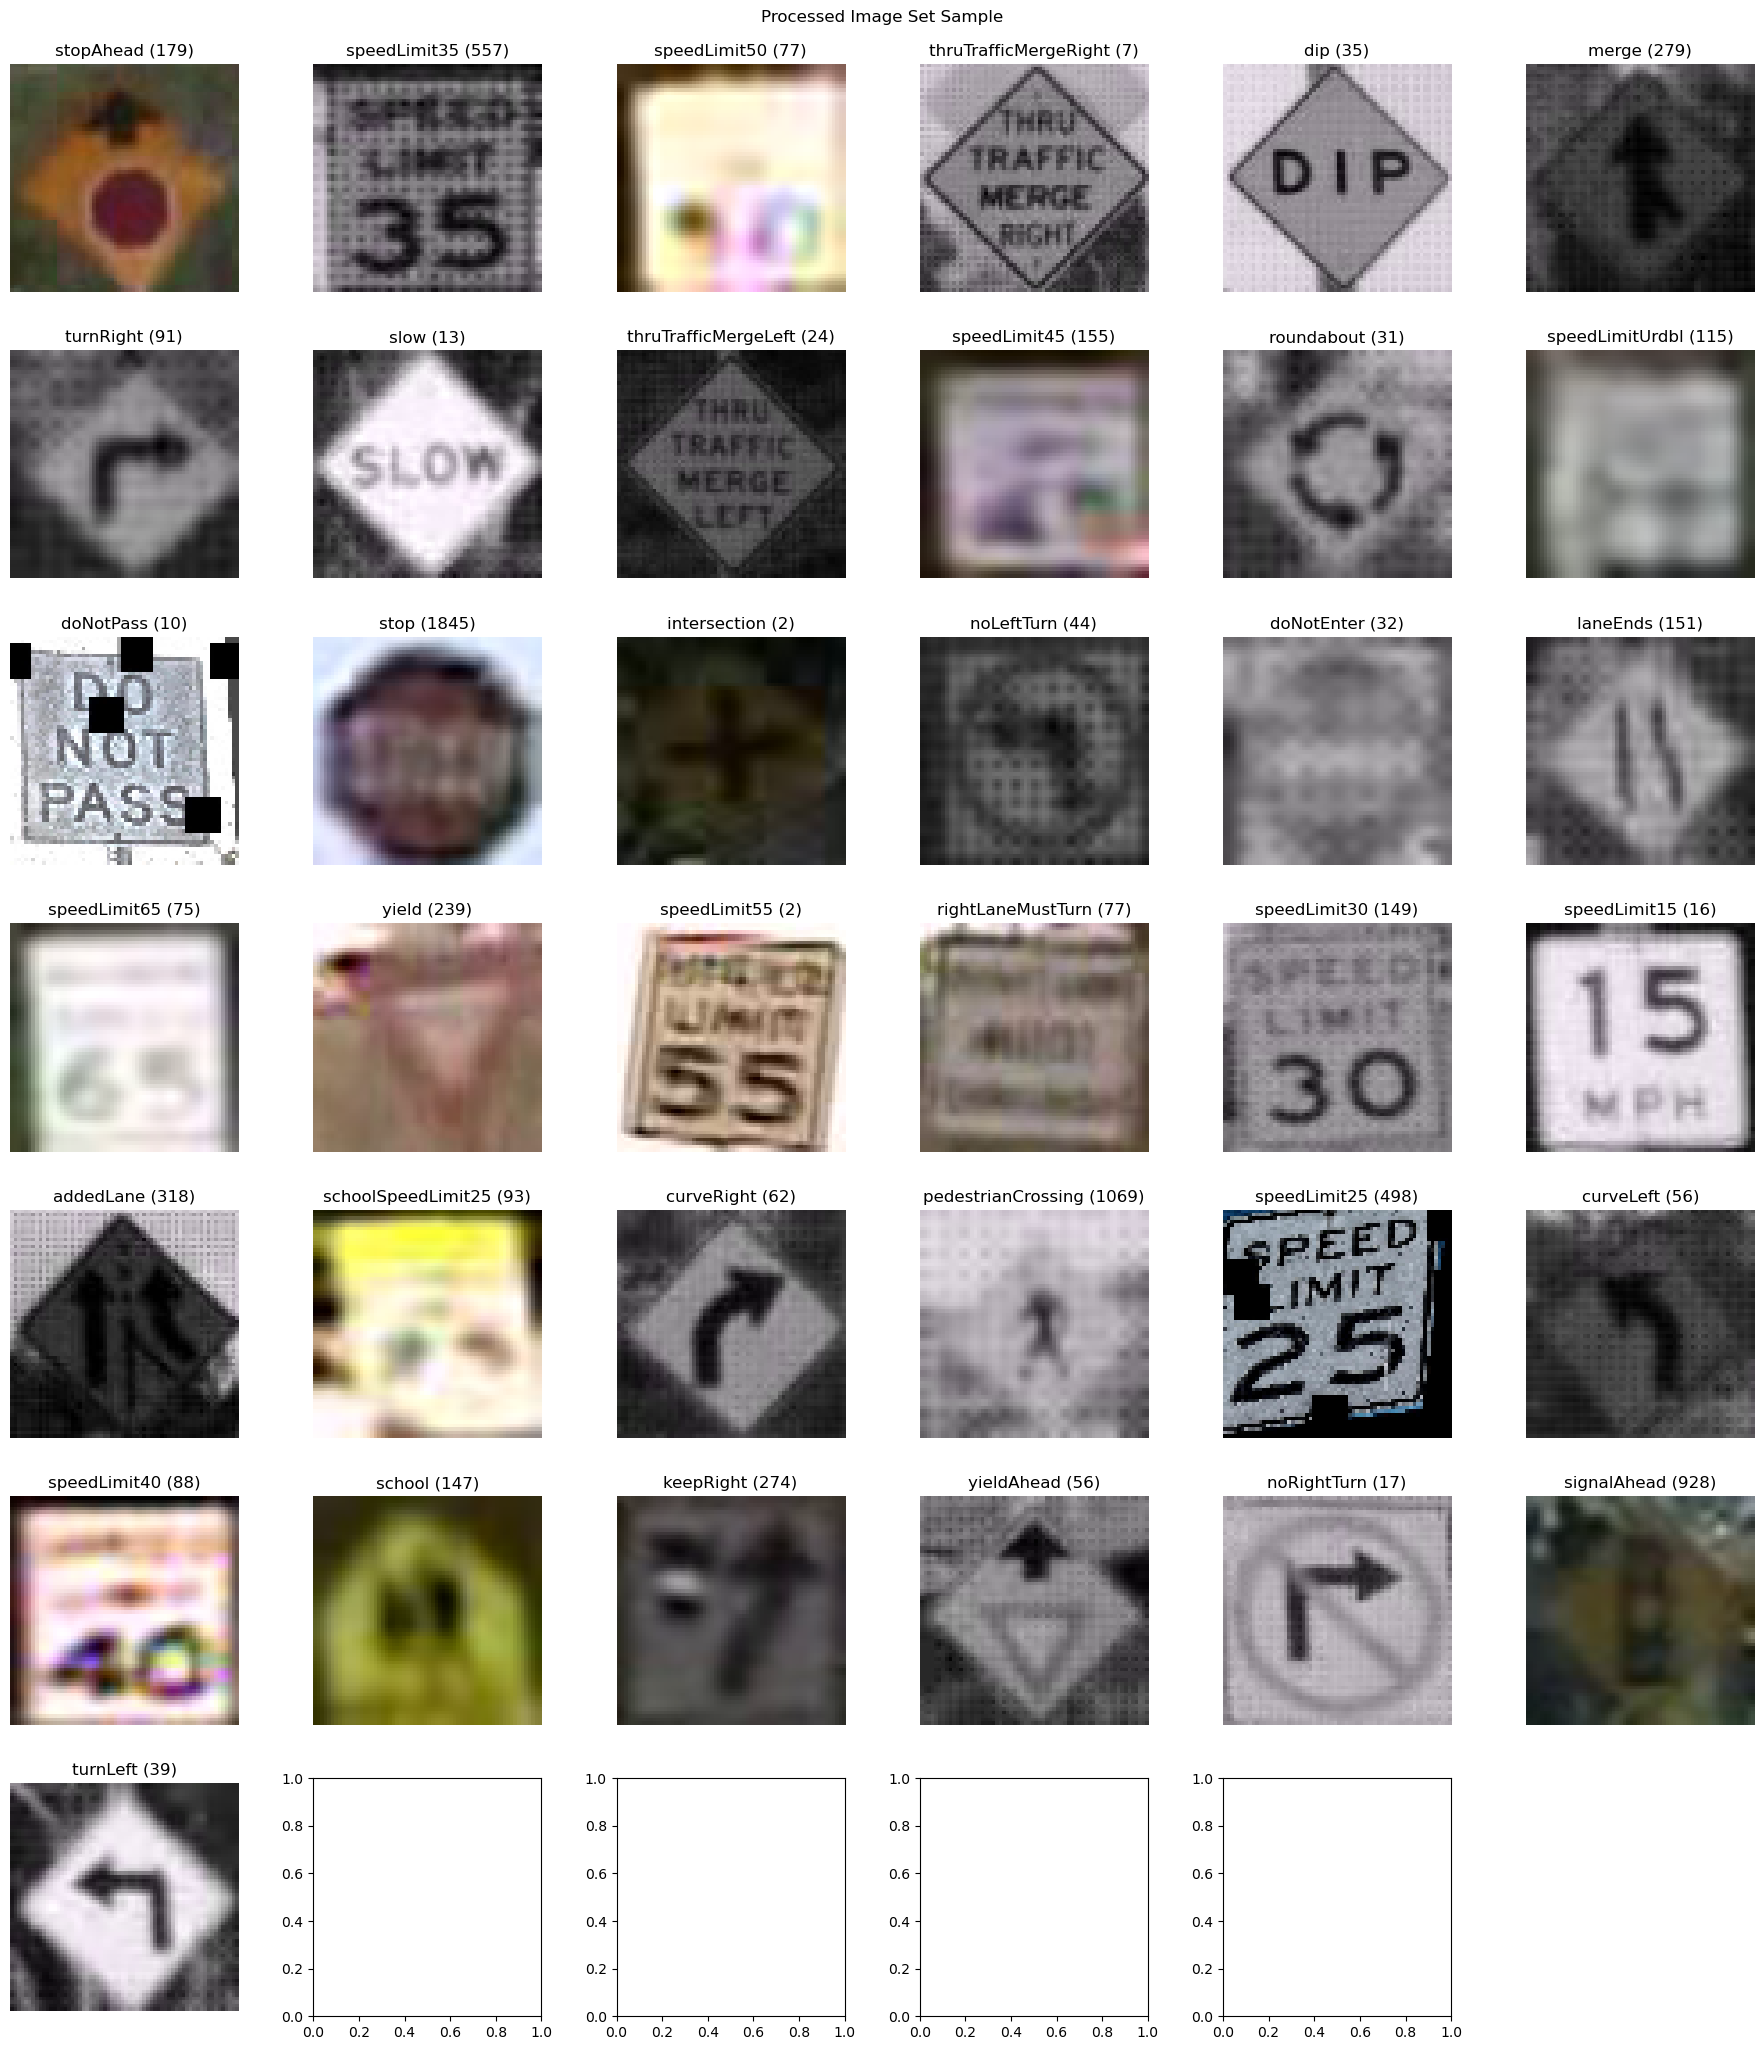

In [24]:
def prune_categories():
    categories=os.listdir(image_dir)
    for category in categories:
        cat_dir = os.path.join(image_dir, category)
        if not os.path.isdir(cat_dir):
            print(f"Removing non-directory {cat_dir}")
            os.remove(cat_dir)
        if 'Advisory' in category or 'truck' in category or 'zoneAhead' in category or '.DS_Store' in category:
            print(f"Pruning directory {cat_dir}")
            shutil.rmtree(cat_dir)
            continue
        for file in os.listdir(cat_dir):
            if '.png' not in file:
                fpath = os.path.join(cat_dir, file)
                print(f'Removing non-image file {fpath}')
                os.remove(fpath)

category_count = {}

def display_random_image_for_each_category_and_count_images():    
    categories=os.listdir(image_dir)

    # Determine optimal subplot layout
    n = len(categories)
    result = sizing_algorithm(n)
    a = result['a']  # Number of columns
    b = result['b']  # Number of rows
    # Create the figure with specified subplots
    fig, axs = plt.subplots(b, a, figsize=(a * 3, b * 3))
    fig.suptitle('Processed Image Set Sample')
    plt.axis('off')  # Turn off the main plot axes

    # Flatten axs array for easier iteration if it's multidimensional
    axs = axs.ravel() if a * b > 1 else [axs]
    
    for i, category in enumerate(categories):
    
        if i >= a * b:
            print(f"Whoa! {i=} >= {a}*{b}")
            break  # Stop if more tags than subplots available
        
        cat_dir = os.path.join(image_dir, category)
        images=os.listdir(cat_dir)
    
        n_images = len(images)
        category_count[category] = n_images
        img_name = random.choice(images)
        img_path = os.path.join(cat_dir, img_name)
        #print(img_path)
        img = cv2.imread(img_path)
        try:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except Exception as ex:
            print(f'Ignoring non-image {img_path} due to {type(ex)} {ex}')
            continue
        axs[i].imshow(img)
        axs[i].set_title(f'{category} ({n_images})')
        axs[i].axis('off')  # Hide axes for individual subplot

    plt.tight_layout(pad=2)
    plt.show()

prune_categories()
display_random_image_for_each_category_and_count_images()

7850


/var/folders/bc/hf73xq254_1fzjgx5rcvbmd00000gn/T/ipykernel_61542/4201669443.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20', len(category_count))  # 'tab20' supports up to 20 unique colors
/var/folders/bc/hf73xq254_1fzjgx5rcvbmd00000gn/T/ipykernel_61542/4201669443.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


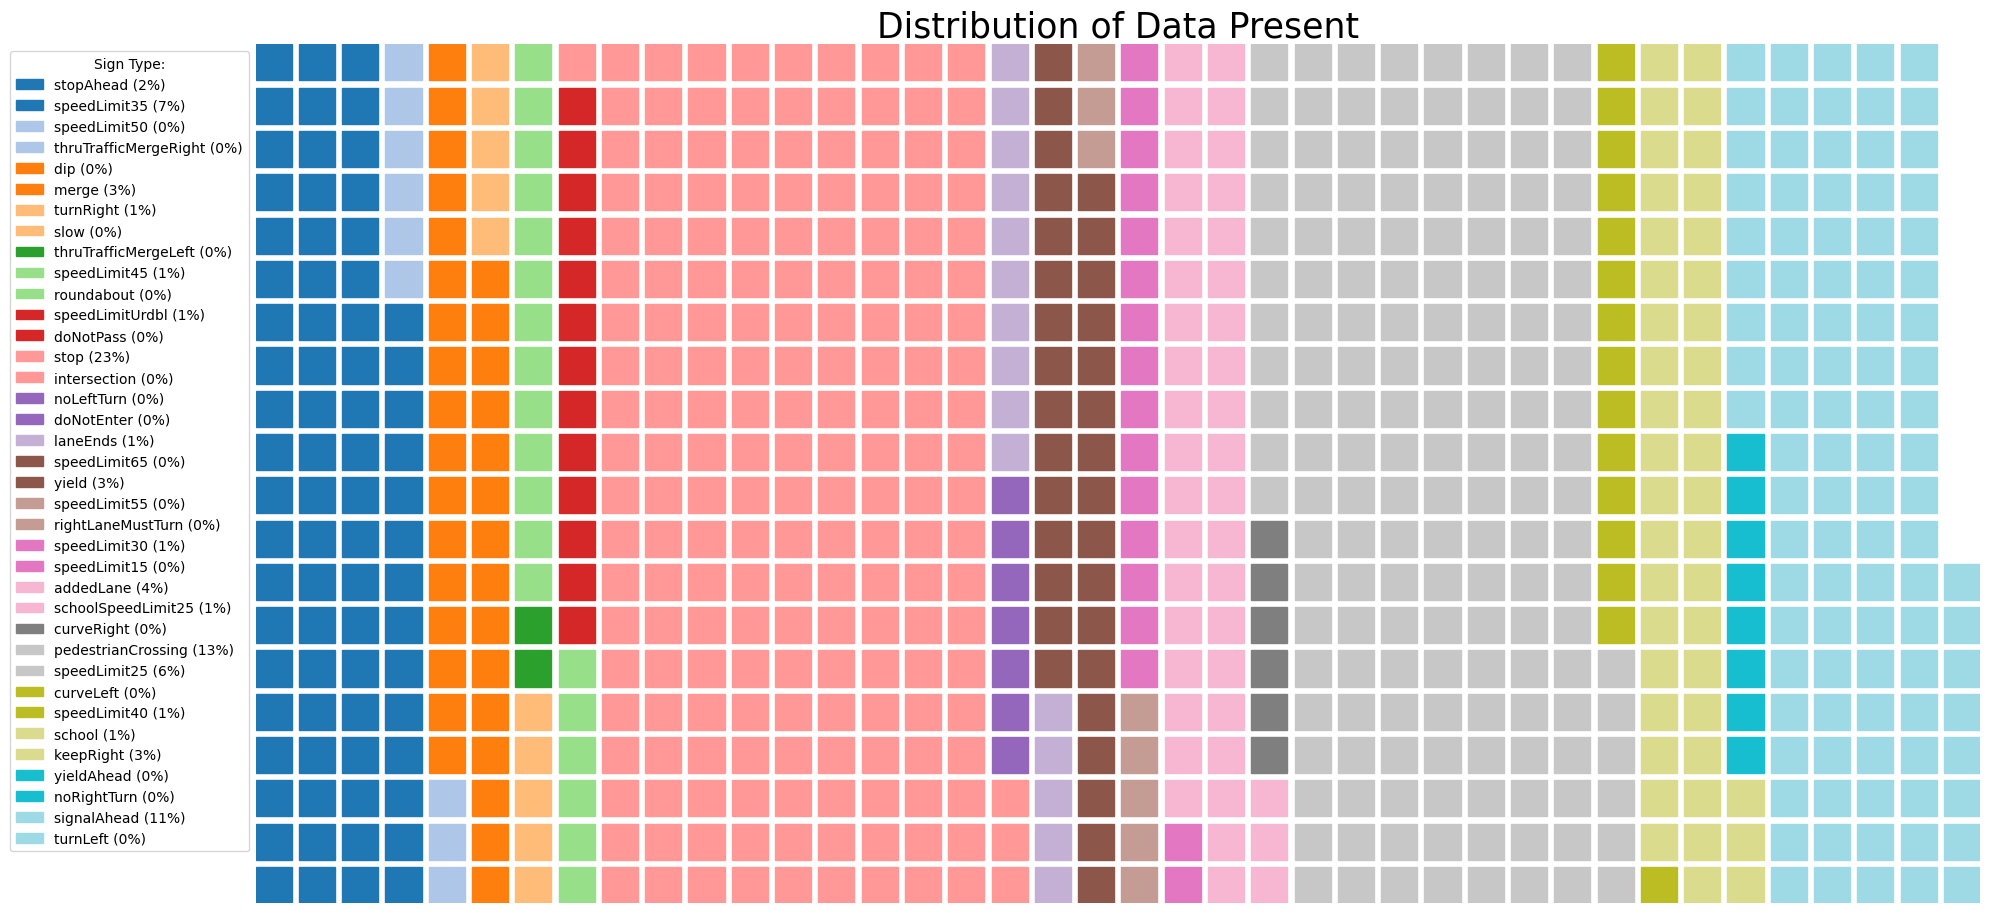

In [32]:
# Assuming value_table is already set correctly

# Convert 'value' column to dictionary with 'label' as keys
values = category_count

# Sum of all values to calculate the total blocks
n_tot = sum(category_count.values())
print(n_tot)  # Debugging: print total number of values

# Define the number of columns
col_num = 10

# Define number of categories and assign colors
cmap = get_cmap('tab20', len(category_count))  # 'tab20' supports up to 20 unique colors
# Generate colors from the colormap
colors = [cmap(i) for i in range(len(category_count))]

# Create labels with percentages
labels = [f"{label} ({int((value) / n_tot * 100)}%)" for label, value in values.items()]
counts = [ v/10 for v in values.values() ]
fig = plt.figure(
    FigureClass=Waffle,
    values=counts,
    rows = 20,
    colors=colors,
    figsize=(20, 20),
    title={
        'label': 'Distribution of Data Present',
        'loc': 'center',
        'fontdict': {'fontsize': 25}
    },
    labels=labels,
    legend={
        'title': 'Sign Type:',
        'loc': 'best',
        'bbox_to_anchor': (0, 1),
    }
)
fig.show()

### Moving on now from Preprocessing to building a model using PyTorch to classify signs

**Setup Data to PyTorch formatting and seperate Train, Test, and Validation Sets:**

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image using cv2
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        # Convert the NumPy array to a PIL Image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.labels[idx]

# Define transformations including ToTensor at the end
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image if needed
    transforms.ToTensor(),  # Converts to tensor and scales pixels between 0 and 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet values
])

# Current directory and image directory
current_directory = os.getcwd()
image_dir = os.path.join(current_directory, 'reshaped_image_data')
categories = os.listdir(image_dir)
num_classes = len(categories)

# Dictionary to map categories to integers
category_dict = {category: index for index, category in enumerate(categories)}

# Lists to store image paths and labels
image_paths = []
labels = []

# Load image paths and labels
for category in categories:
    cat_dir = os.path.join(image_dir, category)
    images = os.listdir(cat_dir)
    for img_name in images:
        img_path = os.path.join(cat_dir, img_name)
        image_paths.append(img_path)
        labels.append(category_dict[category])

# Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Assuming images are already the right size, this may be skipped
    transforms.ToTensor(),  # Converts images to PyTorch tensors and scales [0, 255] -> [0.0, 1.0]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet norms
])

# Split the data into training and validation
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.5, stratify=labels, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)

# Create datasets
train_dataset = CustomImageDataset(train_paths, train_labels, transform)
val_dataset = CustomImageDataset(val_paths, val_labels, transform)
test_dataset = CustomImageDataset(test_paths, test_labels, transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
# Define your model, loss function, optimizer, and data loaders
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        # Fully connected layers block
        self.fc_block = nn.Sequential(
            nn.Linear(256 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 38),
        )

    def forward(self, x):
        # Apply conv_block
        x = self.conv_block(x)
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        # Apply fc_block
        x = self.fc_block(x)
        return x
model = CNN()
#summary(model,(3, 64, 64))
print(model)

CNN(
  (conv_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [14]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [15]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 20
early_stopper = EarlyStopper(patience=3, min_delta=10)
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)
    if early_stopper.early_stop(val_loss):
        print(f'Early stopping  at {val_loss =} after {epoch =}')          
        break

    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}, Train Acc: {100 * correct_train / total_train:.2f}%, Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {100 * correct_val / total_val:.2f}%')


Epoch 1, Train Loss: 0.0740, Train Acc: 97.90%, Val Loss: 0.1844, Val Acc: 97.07%
Epoch 2, Train Loss: 0.0545, Train Acc: 98.63%, Val Loss: 0.1842, Val Acc: 96.05%
Epoch 3, Train Loss: 0.0793, Train Acc: 97.48%, Val Loss: 0.1743, Val Acc: 96.69%
Epoch 4, Train Loss: 0.0762, Train Acc: 98.18%, Val Loss: 0.1442, Val Acc: 96.43%
Epoch 5, Train Loss: 0.0251, Train Acc: 99.33%, Val Loss: 0.1509, Val Acc: 97.45%
Epoch 6, Train Loss: 0.0364, Train Acc: 98.95%, Val Loss: 0.1186, Val Acc: 97.83%
Epoch 7, Train Loss: 0.0537, Train Acc: 98.69%, Val Loss: 0.1086, Val Acc: 97.07%
Epoch 8, Train Loss: 0.0569, Train Acc: 98.76%, Val Loss: 0.0799, Val Acc: 98.09%
Epoch 9, Train Loss: 0.0327, Train Acc: 99.04%, Val Loss: 0.1529, Val Acc: 96.69%
Epoch 10, Train Loss: 0.0630, Train Acc: 98.63%, Val Loss: 0.2952, Val Acc: 96.31%
Epoch 11, Train Loss: 0.0612, Train Acc: 98.34%, Val Loss: 0.2221, Val Acc: 96.94%
Epoch 12, Train Loss: 0.0317, Train Acc: 99.11%, Val Loss: 0.1287, Val Acc: 97.71%
Epoch 13, Tra

In [16]:
# Evaluate on test data
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
acc = accuracy_score(y_pred, y_true)
print(f'Test Acc: {100*acc:.2f}%')

Test Acc: 97.15%


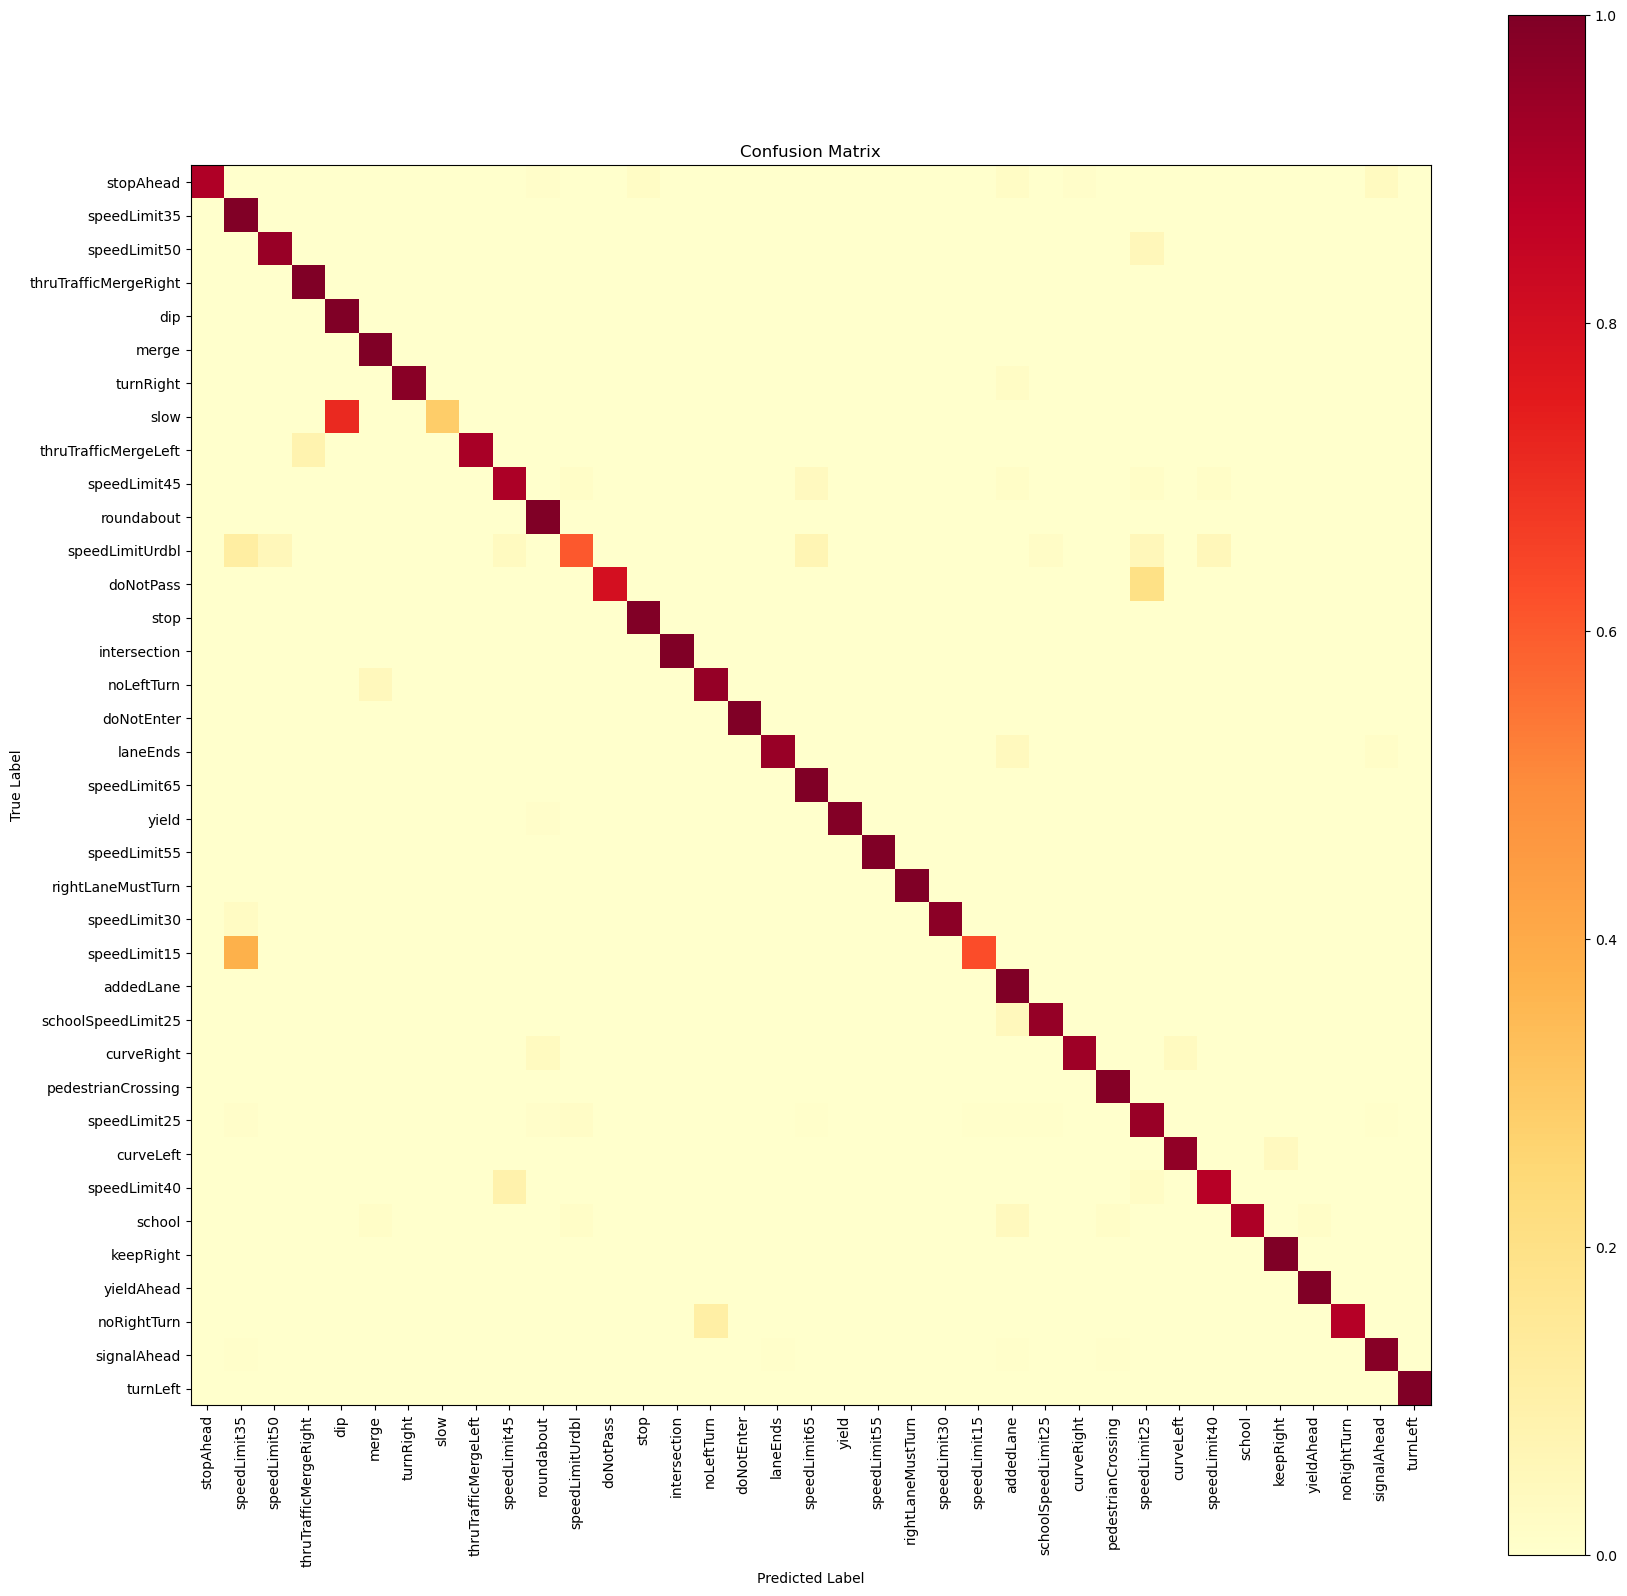

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp_cm = ConfusionMatrixDisplay(cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(20, 20))
disp_cm.plot(ax=ax, include_values=False, xticks_rotation='vertical', cmap='YlOrRd')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import torch
from PIL import Image

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)
# Set the device
# Load the pre-trained YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)  # Use 'custom' for custom trained models

# Send the model to the device
model.to(device)

# Set the model to evaluation mode
model.eval()

# Load an image with PIL
img_path = '/Users/eashan/Coursera/Deep Learning Final/vid0/frameAnnotations-vid_cmp2.avi_annotations/stop_1323804497.avi_image14.png'
img = Image.open(img_path)

# Perform inference
results = model(img)

# Results show detected bounding boxes with class names and confidence scores
results.show()

# To get bounding box coordinates
for *box, conf, cls in results.xyxy[0].to(device):  # Move results to the right device
    # xyxy is the format [x_min, y_min, x_max, y_max]
    print(f'Class: {int(cls)}, Confidence: {conf.item():.2f}, Bounding box: {[int(b) for b in box]}')